# Prepare data

In [1]:
USE_SUBSET = True

In [2]:
import pandas as pd
from fastai.vision.all import *
from random import sample


In [5]:
df_articles = pd.read_parquet("Data/processed_articles.parquet")
df_articles.head()

,article_id,product_code,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,value_binned,path
0,0108775015,0108775,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,4,Rawdata/images/010/0108775015.jpg
1,0108775044,0108775,Strap top,Vest top,Garment Upper body,Solid,White,Light,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,4,Rawdata/images/010/0108775044.jpg
2,0108775051,0108775,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,4,Rawdata/images/010/0108775051.jpg
3,0110065001,0110065,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.",4,Rawdata/images/011/0110065001.jpg
4,0110065002,0110065,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.",4,Rawdata/images/011/0110065002.jpg


# Get relevant product groups

In [6]:
counts = df_articles["value_binned"].value_counts()
counts

4    44145
3    25309
2    20191
1    15002
Name: value_binned, dtype: int64

# Prepare a final pandas dataframe

In [7]:
df = df_articles[["article_id", "product_code", "value_binned", "path"]]
df.head()


,article_id,product_code,value_binned,path
0,0108775015,0108775,4,Rawdata/images/010/0108775015.jpg
1,0108775044,0108775,4,Rawdata/images/010/0108775044.jpg
2,0108775051,0108775,4,Rawdata/images/010/0108775051.jpg
3,0110065001,0110065,4,Rawdata/images/011/0110065001.jpg
4,0110065002,0110065,4,Rawdata/images/011/0110065002.jpg


# Subset the data

In [8]:
if USE_SUBSET:
    df = df.groupby(['value_binned']).apply(lambda x: x.sample(frac=0.01)) 
    df = df.drop(columns=['value_binned']).reset_index().drop(columns=['level_1'])
    print(df["value_binned"].value_counts())

4    441
3    253
2    202
1    150
Name: value_binned, dtype: int64


# Train / Test Split
 we want to do a stratified split on the product code

In [9]:
unique_values = list(df["product_code"].unique())
k = round(len(unique_values) * 0.2)
sample_result = sample(unique_values, k)
df_samples = pd.DataFrame(sample_result, columns=['product_code'])
df_samples["is_valid"] = False
df = df.merge(df_samples, on='product_code', how='left')
df['is_valid'] = df['is_valid'].fillna(True)
df.head()

,value_binned,article_id,product_code,path,is_valid
0,1,0685424001,0685424,Rawdata/images/068/0685424001.jpg,False
1,1,0925170001,0925170,Rawdata/images/092/0925170001.jpg,True
2,1,0813022001,0813022,Rawdata/images/081/0813022001.jpg,True
3,1,0601900002,0601900,Rawdata/images/060/0601900002.jpg,True
4,1,0613539001,0613539,Rawdata/images/061/0613539001.jpg,True


In [12]:
# refactor get_x and get_y to functions if we want to serialize the learner later
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=ColSplitter(col='is_valid'),
    get_x=lambda r: r["path"],
    get_y=lambda r: r["value_binned"],
    item_tfms=RandomResizedCrop(128),
    batch_tfms=aug_transforms(),
)


In [13]:
dls = dblock.dataloaders(df, bs=64)


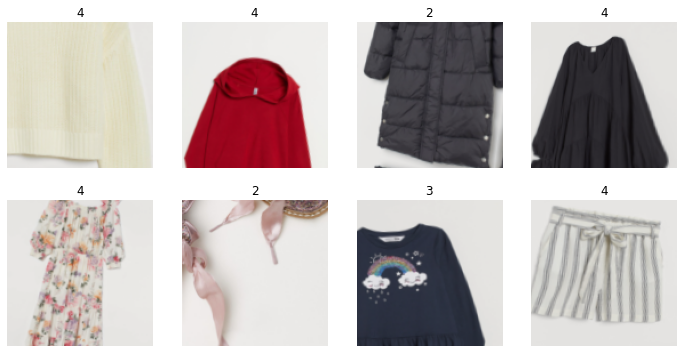

In [14]:
dls.train.show_batch(ncols=4, nrows=2)


In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch,train_loss,valid_loss,error_rate,time


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

KeyboardInterrupt: 

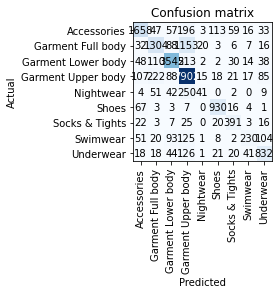

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


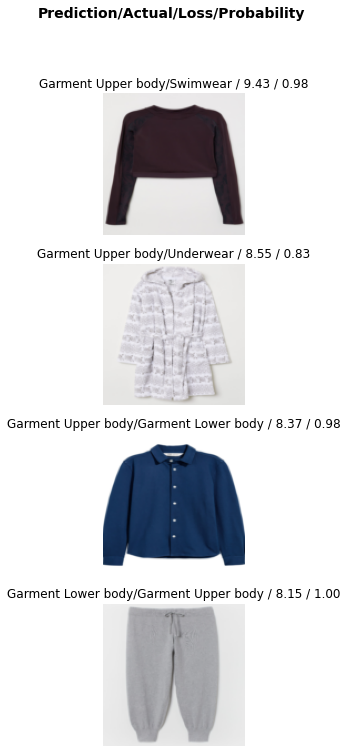

In [20]:
interp.plot_top_losses(4, nrows=4)
